# Importando módulos 

In [1]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from IPython.display import HTML
from IPython import display

# Inputs e Outputs

In [2]:
#FOLDER_OUTPUT = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/'
FOLDER_OUTPUT = '/media/sysop/14f7ead0-5dcb-4557-a139-55dbb404d11a/diogoloc/dados_posdoc/Gliders_DATA/OUTPUT/'

#MSEED_INPUT = "/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"
MSEED_INPUT = "/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"

METADATA_OUTPUT = "/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/METADATA/"

filename_csv = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv'

campanha_csv = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/Equipamentos/informacoes_sensores_gliders/Dados_campanhas_Gliders.xls'

# Extraindo informações dos arquivos ".mseed" reamostrados

In [3]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [4]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    root_file = i
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    sampling_rate = st[0].stats.sampling_rate
    npts = st[0].stats.npts

    
    df = pd.DataFrame([[root_file],[filename],[mergulho],[stream_number],[starttime],[endtime],[sampling_rate],[npts]], index=['root_file','filename_mseed', 'mergulho', 'stream_number','starttime','endtime','sampling_rate','npts']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [5]:
pandas_mseed_lst = []

with Pool(processes=4) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

0it [00:00, ?it/s]


In [6]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [7]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime, format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime, format='%Y-%m-%d %H:%M:%S')

In [8]:
dataframe_mseed_final['date'] = dataframe_mseed_final['starttime'].dt.date

In [9]:
dataframe_mseed_final

,root_file,filename_mseed,mergulho,stream_number,starttime,endtime,sampling_rate,npts,date
0,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0001au_005_151112_135641,0001,005,2015-11-12 13:56:41,2015-11-12 13:57:00.980,100.0,1999,2015-11-12
1,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0001au_001_151112_134841,0001,001,2015-11-12 13:48:41,2015-11-12 13:50:40.930,100.0,11994,2015-11-12
2,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0001au_003_151112_135241,0001,003,2015-11-12 13:52:41,2015-11-12 13:54:40.930,100.0,11994,2015-11-12
3,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0001au_004_151112_135441,0001,004,2015-11-12 13:54:41,2015-11-12 13:56:40.930,100.0,11994,2015-11-12
4,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0002au_004_151112_144218,0002,004,2015-11-12 14:42:18,2015-11-12 14:44:17.930,100.0,11994,2015-11-12
...,...,...,...,...,...,...,...,...,...
124252,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0296au_008_211104_061338,0296,008,2021-11-04 06:13:38,2021-11-04 06:23:37.990,100.0,60000,2021-11-04
124253,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0296au_012_211104_065338,0296,012,2021-11-04 06:53:38,2021-11-04 06:57:21.780,100.0,22379,2021-11-04
124254,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0296au_009_211104_062338,0296,009,2021-11-04 06:23:38,2021-11-04 06:33:37.990,100.0,60000,2021-11-04
124255,/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad0...,pa0296au_010_211104_063338,0296,010,2021-11-04 06:33:38,2021-11-04 06:43:37.990,100.0,60000,2021-11-04


# Extraindo informações do arquivo ".csv" com as campanhas

In [10]:
ciclos_dataframe_csv = pd.read_excel(campanha_csv)

In [11]:
ciclos_dataframe_csv

,Sistema,Ciclo,starttime,endtime,Fs,nBits,Hidrofone,PreAmp,N/S
0,GLIDER,1,2015-11-10,2015-12-20,125000,16,911006,1501,SG618
1,GLIDER,2,2016-01-08,2016-02-02,125000,16,911006,1501,SG618
2,GLIDER,3,2016-02-02,2016-04-20,125000,24,911008,1503,SG612
3,GLIDER,4,2016-04-20,2016-07-07,125000,24,911006,1501,SG612
4,GLIDER,5,2016-07-07,2016-08-16,125000,24,911008,1503,SG612
...,...,...,...,...,...,...,...,...,...
89,GLIDER,MC_C026,2023-06-22,2023-07-30,128000,24,G003654,AMAR-G4,SL976
90,GLIDER,ME_C012,2023-06-20,2023-08-01,128000,24,C000811,AMAR-G4,SL977
91,GLIDER,MC_C027,2023-12-30,2023-12-30,128000,24,G003654,AMAR-G4,SL975
92,GLIDER,MC_C028,2023-08-03,2023-09-09,128000,24,F001108,AMAR-G4,SL977


In [12]:
ciclos_dataframe_csv['starttime'] = pd.to_datetime(ciclos_dataframe_csv.starttime, format='%Y-%m-%d %H:%M:%S').dt.date
ciclos_dataframe_csv['endtime'] = pd.to_datetime(ciclos_dataframe_csv.endtime, format='%Y-%m-%d %H:%M:%S').dt.date

In [13]:
ciclos_dataframe_csv['Ciclo_new'] = range(len(ciclos_dataframe_csv))
ciclos_dataframe_csv['Hidrofone'] = ciclos_dataframe_csv['Hidrofone'].astype(str)
ciclos_dataframe_csv['PreAmp'] = ciclos_dataframe_csv['PreAmp'].astype(str)

In [14]:
ciclos_dataframe_csv

,Sistema,Ciclo,starttime,endtime,Fs,nBits,Hidrofone,PreAmp,N/S,Ciclo_new
0,GLIDER,1,2015-11-10,2015-12-20,125000,16,911006,1501,SG618,0
1,GLIDER,2,2016-01-08,2016-02-02,125000,16,911006,1501,SG618,1
2,GLIDER,3,2016-02-02,2016-04-20,125000,24,911008,1503,SG612,2
3,GLIDER,4,2016-04-20,2016-07-07,125000,24,911006,1501,SG612,3
4,GLIDER,5,2016-07-07,2016-08-16,125000,24,911008,1503,SG612,4
...,...,...,...,...,...,...,...,...,...,...
89,GLIDER,MC_C026,2023-06-22,2023-07-30,128000,24,G003654,AMAR-G4,SL976,89
90,GLIDER,ME_C012,2023-06-20,2023-08-01,128000,24,C000811,AMAR-G4,SL977,90
91,GLIDER,MC_C027,2023-12-30,2023-12-30,128000,24,G003654,AMAR-G4,SL975,91
92,GLIDER,MC_C028,2023-08-03,2023-09-09,128000,24,F001108,AMAR-G4,SL977,92


# Extraindo informações do arquivo ".csv" com as localizações (lat,lon,dep)

In [15]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

,time,filename,latitude,longitude,depth
0,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841_rms_spl3.mat,-23.825157,-42.495483,1.314286
1,2015-11-12 13:49:41.000001,pa0001au_001_151112_134841_rms_spl3.mat,-23.824950,-42.495487,7.415555
2,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041_rms_spl3.mat,-23.824745,-42.495490,15.776000
3,2015-11-12 13:51:41.000004,pa0001au_002_151112_135041_rms_spl3.mat,-23.824540,-42.495495,24.372000
4,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241_rms_spl3.mat,-23.824331,-42.495500,32.912000
...,...,...,...,...,...
547748,2021-11-04 06:52:38.000000,pa0296au_011_211104_064338_rms_spl3.mat,-24.461742,-42.471264,866.012900
547749,2021-11-04 06:53:37.999997,pa0296au_012_211104_065338_rms_spl3.mat,-24.461819,-42.471302,873.586100
547750,2021-11-04 06:54:38.000003,pa0296au_012_211104_065338_rms_spl3.mat,-24.461980,-42.471510,879.579600
547751,2021-11-04 06:55:38.000000,pa0296au_012_211104_065338_rms_spl3.mat,-24.462152,-42.471740,884.380700


In [16]:
df_csv = dataframe_csv.groupby("filename").agg(pd.Series.tolist)

In [17]:
df_csv['filename_mseed'] = df_csv.index.str.replace('_rms_spl3.mat', '')

In [18]:
df_csv.sort_values(by='time')

,time,latitude,longitude,depth,filename_mseed
filename,,,,,
pa0001au_001_151112_134841_rms_spl3.mat,"[2015-11-12 13:48:40.999995, 2015-11-12 13:49:...","[-23.825157, -23.82495]","[-42.495483, -42.495487]","[1.3142858, 7.4155555]",pa0001au_001_151112_134841
pa0001au_002_151112_135041_rms_spl3.mat,"[2015-11-12 13:50:40.999998, 2015-11-12 13:51:...","[-23.824745, -23.82454]","[-42.49549, -42.495495]","[15.776, 24.372]",pa0001au_002_151112_135041
pa0001au_003_151112_135241_rms_spl3.mat,"[2015-11-12 13:52:41.000001, 2015-11-12 13:53:...","[-23.824331, -23.824125]","[-42.4955, -42.495502]","[32.912, 41.34]",pa0001au_003_151112_135241
pa0001au_004_151112_135441_rms_spl3.mat,"[2015-11-12 13:54:41.000004, 2015-11-12 13:55:41]","[-23.82392, -23.823713]","[-42.495506, -42.495506]","[48.91, 52.824]",pa0001au_004_151112_135441
pa0002au_001_151112_143618_rms_spl3.mat,"[2015-11-12 14:36:17.999998, 2015-11-12 14:37:...","[-23.817575, -23.81744]","[-42.49506, -42.494965]","[1.4671428, 9.36]",pa0002au_001_151112_143618
...,...,...,...,...,...
pa0296au_008_211104_061338_rms_spl3.mat,"[2021-11-04 06:13:37.999999, 2021-11-04 06:14:...","[-24.457632, -24.457657, -24.457726, -24.45786...","[-42.470257, -42.470303, -42.470325, -42.47033...","[550.4096, 559.3073, 567.8462, 575.10706, 582....",pa0296au_008_211104_061338
pa0296au_009_211104_062338_rms_spl3.mat,"[2021-11-04 06:23:38.000003, 2021-11-04 06:24:...","[-24.458628, -24.458672, -24.45872, -24.458822...","[-42.47047, -42.470528, -42.470562, -42.470573...","[629.96436, 637.68353, 646.56323, 654.6224, 66...",pa0296au_009_211104_062338
pa0296au_010_211104_063338_rms_spl3.mat,"[2021-11-04 06:33:37.999998, 2021-11-04 06:34:...","[-24.459415, -24.459513, -24.45957, -24.45963,...","[-42.4708, -42.470802, -42.470856, -42.4709, -...","[706.7263, 715.5506, 722.5956, 730.11316, 737....",pa0296au_010_211104_063338


In [19]:
def name_to_mergulho_stream(filename):
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]

    if 'pa' in filename.split('_')[2]:
        mergulho = filename.split('_')[2].split('a')[1]
    
    return mergulho

In [20]:
def calcular_media(lista):
    if len(lista) == 0:
        return None  # Retorna None se a lista estiver vazia para evitar erros
    else:
        return pd.Series(lista).mean()

In [21]:
def flatten(l):
    return l[0]

In [22]:
df_csv['mergulho'] = df_csv['filename_mseed'].apply(name_to_mergulho_stream)

In [23]:
df_csv['date'] = df_csv['time'].apply(calcular_media).dt.date

In [24]:
df_csv

,time,latitude,longitude,depth,filename_mseed,mergulho,date
filename,,,,,,,
160708_172008_pa0003au_001_rms_spl3.mat,"[2016-07-08 17:20:07.999999, 2016-07-08 17:21:...","[-24.391026, -24.391314, -24.391335]","[-43.821663, -43.82173, -43.82174]","[0.9987981, 9.891874, 10.969999]",160708_172008_pa0003au_001,0003,2016-07-08
160708_172307_pa0003au_002_rms_spl3.mat,"[2016-07-08 17:23:07.000004, 2016-07-08 17:24:...","[-24.391356, -24.3916, -24.391617]","[-43.821743, -43.8218, -43.821804]","[12.030156, 23.590548, 24.420235]",160708_172307_pa0003au_002,0003,2016-07-08
160708_172607_pa0003au_003_rms_spl3.mat,"[2016-07-08 17:26:07.000003, 2016-07-08 17:27:...","[-24.391909, -24.39193, -24.392172]","[-43.821873, -43.82188, -43.821938]","[36.456642, 37.333202, 47.245785]",160708_172607_pa0003au_003,0003,2016-07-08
160708_172906_pa0003au_004_rms_spl3.mat,"[2016-07-08 17:29:05.999998, 2016-07-08 17:30:...","[-24.392193, -24.392475, -24.392496]","[-43.82194, -43.822006, -43.82201]","[48.01094, 58.52969, 59.289062]",160708_172906_pa0003au_004,0003,2016-07-08
160708_173205_pa0003au_005_rms_spl3.mat,"[2016-07-08 17:32:05.000003, 2016-07-08 17:33:...","[-24.392744, -24.392765, -24.393057]","[-43.822067, -43.822075, -43.822144]","[68.57156, 69.49031, 80.89149]",160708_173205_pa0003au_005,0003,2016-07-08
...,...,...,...,...,...,...,...
pa0626au_041_160418_075202_rms_spl3.mat,"[2016-04-18 07:52:02.000001, 2016-04-18 07:53:...","[-24.46632, -24.466305]","[-43.148865, -43.14886]","[897.4117, 899.9383]",pa0626au_041_160418_075202,0626,2016-04-18
pa0626au_042_160418_075402_rms_spl3.mat,"[2016-04-18 07:54:02.000004, 2016-04-18 07:55:02]","[-24.466183, -24.466167]","[-43.14885, -43.148846]","[918.85736, 921.4589]",pa0626au_042_160418_075402,0626,2016-04-18
pa0626au_043_160418_075602_rms_spl3.mat,"[2016-04-18 07:56:01.999997, 2016-04-18 07:57:...","[-24.466047, -24.466032]","[-43.148834, -43.14883]","[940.0661, 942.0864]",pa0626au_043_160418_075602,0626,2016-04-18


In [25]:
df_csv['lat'] =  df_csv['latitude'].apply(calcular_media)
df_csv['lon'] =  df_csv['longitude'].apply(calcular_media)
df_csv['dep'] =  df_csv['depth'].apply(calcular_media)
df_csv['time'] =  df_csv['time'].apply(flatten)

In [26]:
df_csv_mean = df_csv.drop(columns=['latitude','longitude','depth',])

In [27]:
df_csv_mean.sort_values(by='date')

,time,filename_mseed,mergulho,date,lat,lon,dep
filename,,,,,,,
pa0005au_015_151112_211136_rms_spl3.mat,2015-11-12 21:11:35.999997,pa0005au_015_151112_211136,0005,2015-11-12,-23.785293,-42.469156,258.771985
pa0004au_011_151112_180207_rms_spl3.mat,2015-11-12 18:02:06.999995,pa0004au_011_151112_180207,0004,2015-11-12,-23.791018,-42.473718,182.740000
pa0004au_012_151112_180407_rms_spl3.mat,2015-11-12 18:04:06.999998,pa0004au_012_151112_180407,0004,2015-11-12,-23.791007,-42.473650,199.017500
pa0006au_001_151112_235913_rms_spl3.mat,2015-11-12 23:59:13.000003,pa0006au_001_151112_235913,0006,2015-11-12,-23.780344,-42.469132,8.517000
pa0004au_013_151112_180607_rms_spl3.mat,2015-11-12 18:06:07.000001,pa0004au_013_151112_180607,0004,2015-11-12,-23.790993,-42.473582,215.688000
...,...,...,...,...,...,...,...
pa0295au_010_211104_015556_rms_spl3.mat,2021-11-04 01:55:55.999999,pa0295au_010_211104_015556,0295,2021-11-04,-24.440742,-42.465287,736.252016
pa0296au_009_211104_062338_rms_spl3.mat,2021-11-04 06:23:38.000003,pa0296au_009_211104_062338,0296,2021-11-04,-24.458968,-42.470625,664.644524
pa0295au_009_211104_014556_rms_spl3.mat,2021-11-04 01:45:56.000005,pa0295au_009_211104_014556,0295,2021-11-04,-24.439859,-42.465195,652.485512


In [28]:
df_csv_meanS = df_csv_mean.sort_values(by='time')

In [29]:
len(sorted(df_csv_mean['filename_mseed'].to_list())) - len(sorted(dataframe_mseed_final['filename_mseed'].to_list()))

-936

# Buscando o nome dos gliders no dataframe das campanhas:

In [30]:
ciclos_dataframe_csv

,Sistema,Ciclo,starttime,endtime,Fs,nBits,Hidrofone,PreAmp,N/S,Ciclo_new
0,GLIDER,1,2015-11-10,2015-12-20,125000,16,911006,1501,SG618,0
1,GLIDER,2,2016-01-08,2016-02-02,125000,16,911006,1501,SG618,1
2,GLIDER,3,2016-02-02,2016-04-20,125000,24,911008,1503,SG612,2
3,GLIDER,4,2016-04-20,2016-07-07,125000,24,911006,1501,SG612,3
4,GLIDER,5,2016-07-07,2016-08-16,125000,24,911008,1503,SG612,4
...,...,...,...,...,...,...,...,...,...,...
89,GLIDER,MC_C026,2023-06-22,2023-07-30,128000,24,G003654,AMAR-G4,SL976,89
90,GLIDER,ME_C012,2023-06-20,2023-08-01,128000,24,C000811,AMAR-G4,SL977,90
91,GLIDER,MC_C027,2023-12-30,2023-12-30,128000,24,G003654,AMAR-G4,SL975,91
92,GLIDER,MC_C028,2023-08-03,2023-09-09,128000,24,F001108,AMAR-G4,SL977,92


In [31]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [32]:
def convert_36(line):
    '''
    Creating the station name according to the hexatrigesimal two-digit algoritm conversion
    '''
    cycle_lst = [i for i in range(500)]
    
    # hexatrigesimal two digit number for each cycle:
    hexatri_lst = [str(np.base_repr(y, 36)).zfill(2) for y in cycle_lst]
    
    #find the nearest date and append the 2-hexatrigesimal-digit:
    return 'G'+line['starttime'].strftime('%y')+hexatri_lst[cycle_lst.index(nearest(cycle_lst,line['Ciclo_new']))]

In [33]:
ciclos_dataframe_csvS = ciclos_dataframe_csv.sort_values(by='starttime')

In [34]:
ciclos_dataframe_csvS['station_nettab'] = ciclos_dataframe_csvS.apply(convert_36,axis=1)

In [35]:
ciclos_dataframe_csvS

,Sistema,Ciclo,starttime,endtime,Fs,nBits,Hidrofone,PreAmp,N/S,Ciclo_new,station_nettab
0,GLIDER,1,2015-11-10,2015-12-20,125000,16,911006,1501,SG618,0,G1500
1,GLIDER,2,2016-01-08,2016-02-02,125000,16,911006,1501,SG618,1,G1601
2,GLIDER,3,2016-02-02,2016-04-20,125000,24,911008,1503,SG612,2,G1602
3,GLIDER,4,2016-04-20,2016-07-07,125000,24,911006,1501,SG612,3,G1603
4,GLIDER,5,2016-07-07,2016-08-16,125000,24,911008,1503,SG612,4,G1604
...,...,...,...,...,...,...,...,...,...,...,...
88,GLIDER,MC_C025,2023-06-21,2023-07-29,128000,24,F001108,AMAR-G4,SL975,88,G232G
89,GLIDER,MC_C026,2023-06-22,2023-07-30,128000,24,G003654,AMAR-G4,SL976,89,G232H
92,GLIDER,MC_C028,2023-08-03,2023-09-09,128000,24,F001108,AMAR-G4,SL977,92,G232K
93,GLIDER,MC_C029,2023-09-24,2023-10-05,128000,24,I000091,AMAR-G4,SL1099,93,G232L


In [36]:
def nettab_name_csv(line):
    '''
    Getting the station name code from other dataframe
    '''
    
    filtro = (line.date >= ciclos_dataframe_csvS["starttime"]) & (line.date <= ciclos_dataframe_csvS["endtime"])
    
    df2 = ciclos_dataframe_csvS[filtro]

    if len(df2) > 0:
        return df2['station_nettab'].values[0],df2['N/S'].values[0],df2['Fs'].values[0],df2['nBits'].values[0],df2['Hidrofone'].values[0],df2['PreAmp'].values[0],df2['Ciclo_new'].values[0]

In [37]:
df_csv_meanS_rows = [row for idx,row in df_csv_meanS.iterrows()]

In [38]:
DF_PACK = []
with Pool(processes=4) as p:
    max_ = len(df_csv_meanS_rows)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(nettab_name_csv,df_csv_meanS_rows):
            pbar.update()
            if result is not None:
                DF_PACK.append(result)

100%|█████████████████████████████████| 123321/123321 [00:28<00:00, 4342.61it/s]


In [39]:
df_csv_meanS['station_nettab'] = [i[0] for i in DF_PACK]
df_csv_meanS['N/S'] = [i[1] for i in DF_PACK]
df_csv_meanS['Fs'] = [i[2] for i in DF_PACK]
df_csv_meanS['nBits'] = [i[3] for i in DF_PACK]
df_csv_meanS['Hidrofone'] = [i[4] for i in DF_PACK]
df_csv_meanS['PreAmp'] = [i[5] for i in DF_PACK]
df_csv_meanS['Ciclo'] = [i[6] for i in DF_PACK]

In [40]:
df_csv_meanS

,time,filename_mseed,mergulho,date,lat,lon,dep,station_nettab,N/S,Fs,nBits,Hidrofone,PreAmp,Ciclo
filename,,,,,,,,,,,,,,
pa0001au_001_151112_134841_rms_spl3.mat,2015-11-12 13:48:40.999995,pa0001au_001_151112_134841,0001,2015-11-12,-23.825054,-42.495485,4.364921,G1500,SG618,125000,16,911006,1501,0
pa0001au_002_151112_135041_rms_spl3.mat,2015-11-12 13:50:40.999998,pa0001au_002_151112_135041,0001,2015-11-12,-23.824642,-42.495492,20.074000,G1500,SG618,125000,16,911006,1501,0
pa0001au_003_151112_135241_rms_spl3.mat,2015-11-12 13:52:41.000001,pa0001au_003_151112_135241,0001,2015-11-12,-23.824228,-42.495501,37.126000,G1500,SG618,125000,16,911006,1501,0
pa0001au_004_151112_135441_rms_spl3.mat,2015-11-12 13:54:41.000004,pa0001au_004_151112_135441,0001,2015-11-12,-23.823816,-42.495506,50.867000,G1500,SG618,125000,16,911006,1501,0
pa0002au_001_151112_143618_rms_spl3.mat,2015-11-12 14:36:17.999998,pa0002au_001_151112_143618,0002,2015-11-12,-23.817508,-42.495013,5.413571,G1500,SG618,125000,16,911006,1501,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pa0296au_008_211104_061338_rms_spl3.mat,2021-11-04 06:13:37.999999,pa0296au_008_211104_061338,0296,2021-11-04,-24.458063,-42.470370,586.134284,G211E,SG656,128000,24,D000342,AMAR-G4,50
pa0296au_009_211104_062338_rms_spl3.mat,2021-11-04 06:23:38.000003,pa0296au_009_211104_062338,0296,2021-11-04,-24.458968,-42.470625,664.644524,G211E,SG656,128000,24,D000342,AMAR-G4,50
pa0296au_010_211104_063338_rms_spl3.mat,2021-11-04 06:33:37.999998,pa0296au_010_211104_063338,0296,2021-11-04,-24.459786,-42.470928,741.901279,G211E,SG656,128000,24,D000342,AMAR-G4,50


In [83]:
df_campanha = df_csv_meanS.groupby(["station_nettab"]).agg(pd.Series.tolist)

In [84]:
df_campanha.columns

Index(['time', 'filename_mseed', 'mergulho', 'date', 'lat', 'lon', 'dep',
       'N/S', 'Fs', 'nBits', 'Hidrofone', 'PreAmp', 'Ciclo'],
      dtype='object')

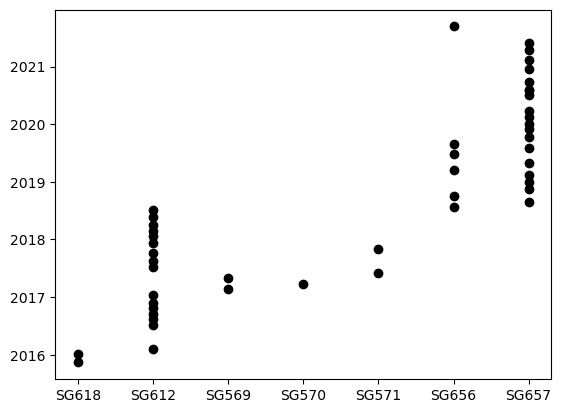

In [85]:
plt.figure()
for i in df_campanha.iterrows():
    plt.plot(i[1]['N/S'][0],i[1].time[0],'ok')

In [86]:
def mergulho_start_end_time(k):
    try:
        files_mseed_HD = [i for i in filenames_MSEED if i.split('/')[-1].split('.')[0] in k[1]['filename_mseed']]
        
        tr_start = obspy.read(files_mseed_HD[0],headonly=True)[0]

        tr_end = obspy.read(files_mseed_HD[-1],headonly=True)[0]
        
        filename_mseed_HD = [i.split('/')[-1].split('.')[0] for i in files_mseed_HD]
        df_file = k[1].to_frame()

        df_nettab = df_file.T
        df_nettab['station_nettab'] = k[0]
        df_nettab['date_start_nettab'] = tr_start.stats.starttime.strftime('%Y/%j:%H%M')
        df_nettab['date_end_nettab'] = tr_end.stats.endtime.strftime('%Y/%j:%H%M')
        df_nettab['filename_mseed_HD'] = [filename_mseed_HD]
        df_nettab['start_lat'] = k[1]['lat'][0]
        df_nettab['end_lat'] = k[1]['lat'][-1]
        df_nettab['start_lon'] = k[1]['lon'][0]
        df_nettab['end_lon'] = k[1]['lon'][-1]
        df_nettab['ciclo'] = k[1]['Ciclo'][0]
        df_nettab['Fs'] = k[1]['Fs'][0]
        df_nettab['nBits'] = k[1]['nBits'][0]        

        #Modelo do Glider
        df_nettab['N/S'] = [k[1]['N/S']]
        df_nettab['modelo'] = k[1]['N/S'][0] 


        #Modelo do Sensor
        df_nettab['hidrofone'] = [k[1]['Hidrofone']]
        if '9' in k[1]['Hidrofone'][0]:
            df_nettab['sensor'] = 'HTI_92_WB'
        if 'D' in k[1]['Hidrofone'][0]:
            df_nettab['sensor'] = 'M36-V35-100'

        #Modelo do Registrador
        df_nettab['preAmp'] = [k[1]['PreAmp']]
        if '1' in k[1]['PreAmp'][0]:
            df_nettab['registrador'] = 'EOS_HM1'
        else:
            df_nettab['registrador'] = k[1]['PreAmp'][0]

        return df_nettab
    
    except:
        pass

In [87]:
end_time = []
with Pool(processes=4) as p:
    with tqdm(total=len(df_campanha)) as pbar:
        for result in p.imap(mergulho_start_end_time,df_campanha.iterrows()):
            pbar.update()
            end_time.append(result)

100%|███████████████████████████████████████████| 48/48 [00:52<00:00,  1.09s/it]


In [88]:
dataframe_campanha_mseed_final = pd.concat(end_time, ignore_index=True)

In [89]:
dataframe_campanha_mseed_final.head(4).sort_values(by='ciclo')

,time,filename_mseed,mergulho,date,lat,lon,dep,N/S,Fs,nBits,...,start_lat,end_lat,start_lon,end_lon,ciclo,modelo,hidrofone,sensor,preAmp,registrador
0,"[2015-11-12 13:48:40.999995, 2015-11-12 13:50:...","[pa0001au_001_151112_134841, pa0001au_002_1511...","[0001, 0001, 0001, 0001, 0002, 0002, 0002, 000...","[2015-11-12, 2015-11-12, 2015-11-12, 2015-11-1...","[-23.825053500000003, -23.8246425, -23.8242279...","[-42.495485, -42.4954925, -42.495501000000004,...","[4.36492065, 20.073999999999998, 37.1260000000...","[SG618, SG618, SG618, SG618, SG618, SG618, SG6...",125000,16,...,-23.825054,-25.079344,-42.495485,-42.272640,0,SG618,"[911006, 911006, 911006, 911006, 911006, 91100...",HTI_92_WB,"[1501, 1501, 1501, 1501, 1501, 1501, 1501, 150...",EOS_HM1
1,"[2016-01-08 10:14:23.000003, 2016-01-08 10:16:...","[pa0001au_001_160108_101423, pa0001au_002_1601...","[0001, 0001, 0001, 0001, 0002, 0002, 0002, 000...","[2016-01-08, 2016-01-08, 2016-01-08, 2016-01-0...","[-23.8396465, -23.8402455, -23.840843999999997...","[-42.50416, -42.504215, -42.5042725, -42.50433...","[4.4947145, 20.937999499999997, 37.24699850000...","[SG618, SG618, SG618, SG618, SG618, SG618, SG6...",125000,16,...,-23.839647,-24.353146,-42.504160,-42.316597,1,SG618,"[911006, 911006, 911006, 911006, 911006, 91100...",HTI_92_WB,"[1501, 1501, 1501, 1501, 1501, 1501, 1501, 150...",EOS_HM1
2,"[2016-02-03 00:00:57.000003, 2016-02-03 00:02:...","[pa0007au_001_160203_000057, pa0007au_002_1602...","[0007, 0007, 0007, 0007, 0007, 0007, 0007, 000...","[2016-02-03, 2016-02-03, 2016-02-03, 2016-02-0...","[-24.3285225, -24.3279755, -24.3273995, -24.32...","[-42.323730499999996, -42.323891, -42.324061, ...","[2.3261719000000003, 22.924609, 42.826563, 60....","[SG612, SG612, SG612, SG612, SG612, SG612, SG6...",125000,24,...,-24.328522,-24.465736,-42.323730,-43.148800,2,SG612,"[911008, 911008, 911008, 911008, 911008, 91100...",HTI_92_WB,"[1503, 1503, 1503, 1503, 1503, 1503, 1503, 150...",EOS_HM1
3,"[2016-07-08 17:20:07.999999, 2016-07-08 17:23:...","[160708_172008_pa0003au_001, 160708_172307_pa0...","[0003, 0003, 0003, 0003, 0003, 0003, 0003, 000...","[2016-07-08, 2016-07-08, 2016-07-08, 2016-07-0...","[-24.391225000000002, -24.391524333333333, -24...","[-43.821711, -43.82178233333334, -43.821897, -...","[7.286890366666666, 20.01364633333333, 40.3452...","[SG612, SG612, SG612, SG612, SG612, SG612, SG6...",125000,24,...,-24.391225,-24.812641,-43.821711,-43.140773,4,SG612,"[911008, 911008, 911008, 911008, 911008, 91100...",HTI_92_WB,"[1503, 1503, 1503, 1503, 1503, 1503, 1503, 150...",EOS_HM1


In [103]:
lines_nettab = []
for i in dataframe_campanha_mseed_final.iterrows():
    for k,l in enumerate(tqdm(i[1]["filename_mseed"],desc='Creating Nettab file')):
        try:
            df_filtrada = dataframe_mseed_final[dataframe_mseed_final["filename_mseed"].str.contains(i[1]["filename_mseed"][k])]
            
            # Station lines (one line per station/sensor/epoch) # code description datalogger%sn seismometer%sn # sampling orientation lat. lon. elev. depth. start end
            #Sl: UNAP "Uni-Iquique/Chile"   DM24%A1383 CMG-3ESP/60%T34622 100 ZNE -20.24393 -70.14041 0.0    0.0 2009/134 
            lines_nettab.append('Sl: '+str(i[1]['station_nettab'])+' "C'+str(i[1]['ciclo']).zfill(2)+':'+i[1]['modelo']+'" '+i[1]['registrador']+' '+str(i[1]['sensor'])+' 100 H(0.0,0.0) '+str(i[1]['lat'][k])[:8]+' '+str(i[1]['lon'][k])[:8]+' 0 0 '+UTCDateTime(str(df_filtrada['starttime'].values[0])).strftime('%Y/%j:%H%M')+' '+UTCDateTime(str(df_filtrada['endtime'].values[0])).strftime('%Y/%j:%H%M'))
        except:
            print(df_filtrada)

Creating Nettab file:  96%|████████████████▎| 3623/3762 [02:48<00:06, 21.88it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  96%|████████████████▍| 3629/3762 [02:48<00:06, 21.59it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  97%|████████████████▍| 3635/3762 [02:49<00:05, 21.53it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  97%|████████████████▍| 3638/3762 [02:49<00:05, 21.35it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  97%|████████████████▍| 3644/3762 [02:49<00:05, 20.55it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  97%|████████████████▍| 3647/3762 [02:49<00:05, 20.02it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  97%|████████████████▌| 3653/3762 [02:50<00:05, 20.05it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  97%|████████████████▌| 3659/3762 [02:50<00:05, 20.37it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  97%|████████████████▌| 3665/3762 [02:50<00:04, 20.87it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  98%|████████████████▌| 3668/3762 [02:50<00:04, 21.04it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  98%|████████████████▌| 3674/3762 [02:51<00:04, 21.27it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  98%|████████████████▋| 3680/3762 [02:51<00:03, 21.48it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  98%|████████████████▋| 3683/3762 [02:51<00:03, 21.48it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  98%|████████████████▋| 3689/3762 [02:51<00:03, 21.53it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  98%|████████████████▋| 3695/3762 [02:51<00:03, 21.31it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  98%|████████████████▋| 3701/3762 [02:52<00:02, 21.40it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  99%|████████████████▊| 3707/3762 [02:52<00:02, 20.62it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  99%|████████████████▊| 3710/3762 [02:52<00:02, 20.38it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  99%|████████████████▊| 3716/3762 [02:52<00:02, 20.92it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  99%|████████████████▊| 3722/3762 [02:53<00:01, 21.18it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  99%|████████████████▊| 3725/3762 [02:53<00:01, 20.96it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  59%|██████████       | 1140/1927 [00:51<00:34, 22.51it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  59%|██████████       | 1143/1927 [00:51<00:35, 22.35it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  60%|██████████▏      | 1149/1927 [00:52<00:34, 22.24it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file:  60%|██████████▏      | 1155/1927 [00:52<00:34, 22.41it/s]

Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []
Empty DataFrame
Columns: [root_file, filename_mseed, mergulho, stream_number, starttime, endtime, sampling_rate, npts, date]
Index: []


Creating Nettab file: 100%|█████████████████| 1927/1927 [01:27<00:00, 22.10it/s]


# Salvando o arquivo de NETTAB e o DATAFRAME:

In [104]:
len(lines_nettab)

120197

In [105]:
with open('/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/NETTAB/glider_nettab_full.txt', 'w') as f:
    for line in lines_nettab:
        f.write(line)
        f.write('\n')

In [53]:
dataframe_campanha_mseed_final.to_feather('/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/NETTAB/df_campanha_glider.feather')

# Renomeando os arquivos ".mseed":

In [ ]:
dataframe_campanha_mseed_final_rows = [row for idx,row in dataframe_campanha_mseed_final.iterrows()]

In [ ]:
rename_files_lst = []
with Pool(processes=4) as p:
    with tqdm(total=len(df_campanha)) as pbar:
        for result in p.imap(get_rename_files,dataframe_campanha_mseed_final_rows):
            pbar.update()
            rename_files_lst.append(result)

In [ ]:
def rename_files(row):
    
    files_mseed_HD = row['filename_mseed_HD']
    
    files_path_mseed_HD = [glob.glob(MSEED_INPUT+'*/*/'+i+'.mseed') for i in files_mseed_HD]
    
    for y in files_path_mseed_HD:
        
        st = obspy.read(y[0])
        st[0].stats.network = 'GL'
        st[0].stats.station = k['station_nettab']
        st[0].stats.channel = 'HHH'

        #<SDSdir>/Year/NET/STA/CHAN.TYPE/NET.STA.LOC.CHAN.TYPE.YEAR.DAY
        #Saving in SDS structure        
        OUTPUT_STREAM = FOLDER_OUTPUT+'MSEED_GL_SDS/'+st[0].stats.starttime.strftime("%Y")+'/'+st[0].stats.network+'/'+st[0].stats.station+'/HHH.D/'
        os.makedirs(OUTPUT_STREAM,exist_ok=True)
        
        station_name_file = st[0].stats.network+'.'+st[0].stats.station+'..'+st[0].stats.channel+'.D.'+st[0].stats.starttime.strftime("%Y.%j.%H.%M.%S")+'.mseed'
        if os.path.exists(OUTPUT_STREAM+station_name_file) == False:
            st.write(OUTPUT_STREAM+station_name_file, format='MSEED')

In [ ]:
with Pool(processes=4) as p:
    with tqdm(total=len(dataframe_campanha_mseed_final)) as pbar:
        for result in p.imap_unordered(rename_files,dataframe_campanha_mseed_final_rows):
            pbar.update()